In [1]:
import pandas as pd
import numpy as np
from automation_process_dataV1_5 import united_functions
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df_ = pd.read_parquet('../../data/raw/data_model/dataset_process_trainV1.0.parquet')#Carga de datos 

In [3]:
df_processed = united_functions(df_)# Script de procesamiento de datos

Entrando a united_functions (script de procesamiento de datos)
-Imputer realizado con exito_
-Transformacion timestamp realizado con exito_
-Extraccion fechas realizado con exito_
-Transformas pelculas no vista realizado con exito_
-Reseteo indice realizado con exito_
-Extraccion año realizado con exito_
-Casteo a entero realizado con exito_
-Extraccion titulo realizado con exito_
-Extraccion genero principal realizado con exito_
-Extraccion genero secundario realizado con exito_
-Extraccion genero terciario realizado con exito_
-Extraccion valoracion rating realizado con exito_
-Eliminacion columnas innecesarias realizado con exito_
--Fin del procesamiento de datos--


In [4]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839920 entries, 0 to 15839919
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   userId           int64  
 1   movieId          int64  
 2   rating           float64
 3   tagId            int64  
 4   relevance        float64
 5   year_rate        int32  
 6   month_rate       int32  
 7   day_rate         int32  
 8   launch_year      int32  
 9   len_title        int64  
 10  main_genre       object 
 11  secondary_genre  object 
 12  third_genre      object 
 13  valoration       object 
dtypes: float64(2), int32(4), int64(4), object(4)
memory usage: 1.4+ GB


In [5]:
# Eliminamos variables userId y movieId, ya que solo entrenaremos lo referente a items (peliculas)
def drop_userId(X):
    X.drop(['userId', 'movieId'], axis =1, inplace = True)
    return X

In [6]:
X_set=drop_userId(df_processed)

In [7]:
# Normalizamos los valores numericos
def normalizer(X):  
    # Divide el DataFrame en columnas numéricas y categóricas
    columns_numeric = X.select_dtypes(include=['int', 'float']).columns

    # normalizacion
    scaler = MinMaxScaler()
    X[columns_numeric] = scaler.fit_transform(X[columns_numeric])

    return X, scaler

In [8]:
X_set,scaler=normalizer(X_set)

In [9]:
# Codificar a numerico las variables categoricas
def categorical_encoder(X):
    # Inicializa el mapeo
    encoding_mapping = {}

    categorical_columns = ['main_genre', 'secondary_genre', 'third_genre', 'valoration']
    for column in categorical_columns:
        # Convierte la columna a tipo 'category'
        X[column] = X[column].astype('category')
        # Guarda el mapeo de la codificación
        encoding_mapping[column] = dict(enumerate(X[column].cat.categories))
        # Aplica la codificación
        X[column] = X[column].cat.codes
    
    return X, encoding_mapping

In [10]:
X_set, encoding_mapping=categorical_encoder(X_set)

Crear autoencoder V1.5

In [11]:
del df_processed
del df_

In [12]:
X_set.shape

(15839920, 12)

In [16]:
# Arquitectura autoencoder
input_size = 12
encoder = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu')
])
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(input_size)
])
full_ae = tf.keras.Sequential([encoder,decoder])

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
full_ae.compile(loss='mean_squared_error', optimizer=optimizer)# optimizador y funcion de perdida

In [18]:
history = full_ae.fit(X_set, X_set, epochs=5, batch_size=32,shuffle=True)

Epoch 1/5
494998/494998 [==============================] - 1134s 2ms/step - loss: 0.6684
Epoch 2/5
494998/494998 [==============================] - 1040s 2ms/step - loss: 0.6072
Epoch 3/5
494998/494998 [==============================] - 998s 2ms/step - loss: 0.5873
Epoch 4/5
494998/494998 [==============================] - 1000s 2ms/step - loss: 0.5784
Epoch 5/5
494998/494998 [==============================] - 1020s 2ms/step - loss: 0.5754


In [19]:
# grafico funcion perdida durante entrenamiento
def plot_model_loss (history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

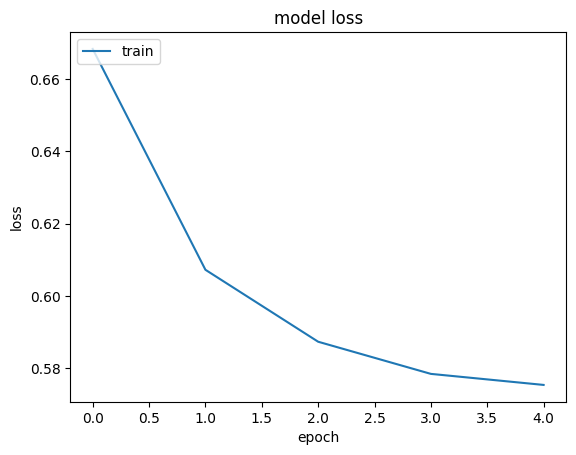

In [20]:
plot_model_loss (history)

Prediccion con conjunto de prueba

In [21]:
df_test = pd.read_parquet('../../data/raw/data_model/dataset_process_testV1.0.parquet')#Carga de datos prueba

In [22]:
df_processed_test = united_functions(df_test)# Script de procesamiento de datos

Entrando a united_functions (script de procesamiento de datos)
-Imputer realizado con exito_
-Transformacion timestamp realizado con exito_
-Extraccion fechas realizado con exito_
-Transformas pelculas no vista realizado con exito_
-Reseteo indice realizado con exito_
-Extraccion año realizado con exito_
-Casteo a entero realizado con exito_
-Extraccion titulo realizado con exito_
-Extraccion genero principal realizado con exito_
-Extraccion genero secundario realizado con exito_
-Extraccion genero terciario realizado con exito_
-Extraccion valoracion rating realizado con exito_
-Eliminacion columnas innecesarias realizado con exito_
--Fin del procesamiento de datos--


In [23]:
userId=df_processed_test.iloc[:, 0].values # Obtenemos los id correpsondientes a usuarios 
movieId=df_processed_test.iloc[:, 1] .values# Obtenemos los id correpsondientes a usuarios 
df_processed_test.drop(['userId', 'movieId'], axis =1, inplace=True)

In [24]:
X_test,scaler=normalizer(df_processed_test)# normalizacion
X_test, encoding_mapping=categorical_encoder(df_processed_test)# encoder

In [25]:
test_loss = full_ae.evaluate(X_test, X_test, batch_size=32)
print(f"Pérdida en el conjunto de prueba: {test_loss}")

123753/123753 [==============================] - 196s 2ms/step - loss: 1.4107
Pérdida en el conjunto de prueba: 1.4106700420379639


In [26]:
prediction_ = full_ae.predict(X_test)# prediccion

123753/123753 [==============================] - 196s 2ms/step


In [27]:
# transformamos en dataframe la prediccion
columns_name = X_test.columns
df_prediction = pd.DataFrame(prediction_, columns=columns_name)

In [28]:
# Desescalar numericos y aplicar valores categoricos por clave de encoding_mapping
def reconvert_types_pred(df, scaler=scaler, encoding_mapping=encoding_mapping):
    # Extraigo del df las columnas no entrenadas por el scaler
    df_scaler = df.drop(['main_genre','secondary_genre','third_genre','valoration'], axis = 1)

    # Aplicar la transformación inversa utilizando el scaler
    df[df_scaler.columns]=scaler.inverse_transform(df_scaler)
    #Convertir a enteros y float los datos correspondientes numericos
    int_values = ['tagId', 'year_rate','month_rate','day_rate','launch_year','len_title']
    df[int_values]=df[int_values].astype(int)
    df['rating']=round(df['rating'].astype(float),1)
    df['relevance']=round(df['relevance'].astype(float),2)
    
    # Sobrescribir las claves del encoding_mapping por sus valores en el DataFrame
    categorical_columns = ['main_genre', 'secondary_genre', 'third_genre', 'valoration']

    #convertir a enteros
    df[categorical_columns] = df[categorical_columns].astype(int)
    # Codificar clave/valor en mapper
    for column in categorical_columns:
        df[column] = df[column].map(encoding_mapping[column])

    return df

In [29]:
df_prediction = reconvert_types_pred(df_prediction)# llamada encoding_mapping

In [30]:
# Añadimos columnas restantes
df_prediction['userId']=userId
df_prediction['movieId']=movieId
# Movemos a primera posicion
movie=df_prediction.pop('movieId')
df_prediction.insert(0, 'movieId', movie)
# Movemos a primera posicion, reemplazando el movie
user=df_prediction.pop('userId')
df_prediction.insert(0, 'userId', user)

In [36]:
df_prediction[df_prediction['userId']==33].head()

,userId,movieId,rating,tagId,relevance,year_rate,month_rate,day_rate,launch_year,len_title,main_genre,secondary_genre,third_genre,valoration
780,33,608,3.8,452,0.55,1957,6,11,1991,16,Animation,Children,Drama,excellent
781,33,1566,1.9,441,0.40,2047,5,10,2009,18,Action,Adventure,Children,bad
782,33,1732,2.2,437,0.48,2067,6,10,1980,17,Animation,Comedy,Sci-Fi,bad
783,33,2002,3.6,370,0.34,1909,7,8,2046,17,Action,Children,Comedy,excellent
784,33,3751,3.8,355,0.74,1958,5,11,2008,12,Adventure,Animation,Comedy,excellent
